In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from pinneit import Circ, Rect, plot_geo, exclude_points_in_region

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2024-11-06 16:57:53.010708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 16:57:53.632486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
Ω = Rect(0, 0, 3, 2)
Γ1 = Circ(1.0, 1.0, 0.1)
Γ2 = Circ(2.0, 1.0, 0.1)

Got a list of 3 geometries.


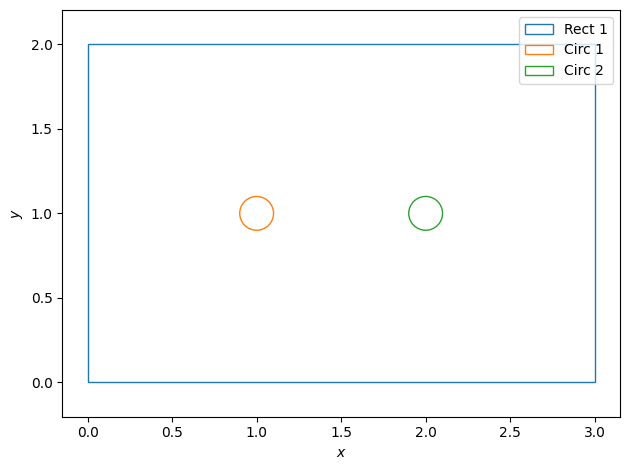

In [4]:
plot_geo([Ω, Γ1, Γ2])

In [5]:
dΓ1_pts = Γ1.generate_edge_points(n_pts=500)
dΓ2_pts = Γ2.generate_edge_points(n_pts=500)


dΩ_pts = Ω.generate_edge_points(n_pts=500)
sΩ_pts = Ω.generate_surface_points(n_pts=5000)
# exclude el. 1
sΩ_pts = exclude_points_in_region(sΩ_pts, Γ1)
# exclude el. 2
sΩ_pts = exclude_points_in_region(sΩ_pts, Γ2)

print(dΓ1_pts.shape, dΓ2_pts.shape, dΩ_pts.shape, sΩ_pts.shape)

(500, 2) (500, 2) (500, 2) (4941, 2)


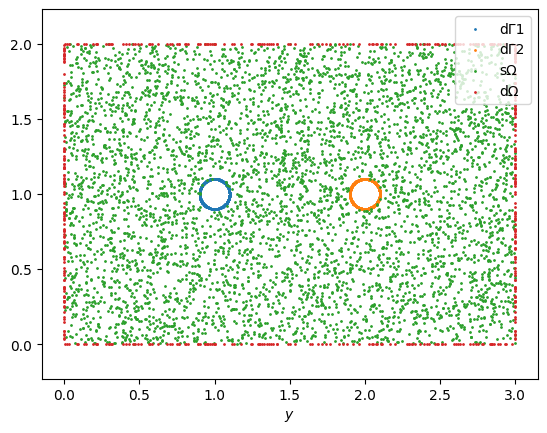

In [6]:
plt.scatter(dΓ1_pts[:, 0], dΓ1_pts[:, 1], s=1, label="dΓ1")
plt.scatter(dΓ2_pts[:, 0], dΓ2_pts[:, 1], s=1, label="dΓ2")
plt.scatter(sΩ_pts[:, 0], sΩ_pts[:, 1], s=1, label="sΩ")
plt.scatter(dΩ_pts[:, 0], dΩ_pts[:, 1], s=1, label="dΩ")
plt.xlabel("$x$")
plt.xlabel("$y$")
plt.axis("equal")
plt.legend()
plt.show()

In [8]:
# TBD: write function for automatic BCs
X_b = np.concatenate((dΩ_pts, dΓ1_pts, dΓ2_pts))
y_b = np.concatenate(
    (
        np.zeros(dΩ_pts.shape[0]),
        np.ones(dΓ1_pts.shape[0]) * 1,
        np.ones(dΓ2_pts.shape[0]) * -1,
    )
)
assert X_b.shape[0] == y_b.shape[0]
shffls_idx = np.random.permutation(y_b.shape[0])

X = X_b[shffls_idx]
y = y_b[shffls_idx]

Pts = tf.constant(sΩ_pts, dtype=tf.float32)
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

In [9]:
Pts.shape, X.shape, y.shape

(TensorShape([4941, 2]), TensorShape([1500, 2]), TensorShape([1500]))

In [10]:
X_f, X_b, y_b = Pts, X, y

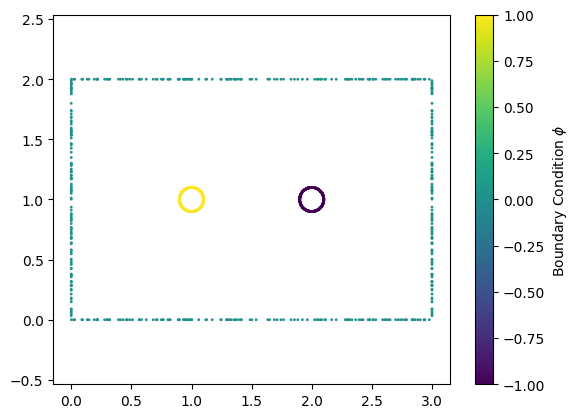

In [11]:
plt.scatter(X_b[:, 0], X_b[:, 1], c=y_b, s=1)
plt.axis("equal")
plt.colorbar(label="Boundary Condition $\phi$")
plt.show()

In [12]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(28, activation="tanh")
        self.dense2 = tf.keras.layers.Dense(28, activation="tanh")
        self.dense3 = tf.keras.layers.Dense(28, activation="tanh")

        self.dense7 = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        # x = self.dense4(x)
        # x = self.dense5(x)
        # x = self.dense6(x)
        x = self.dense7(x)
        return x


lambda1, lambda2 = 1, 1e-2


# Define the loss function
@tf.function
def compute_loss(model, X_f, X_b, y_b):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(X_f)
        phi = model(X_f)
        phi_x = tape1.gradient(phi, X_f)[:, 0:1]
        phi_y = tape1.gradient(phi, X_f)[:, 1:2]
    phi_xx = tape1.gradient(phi_x, X_f)[:, 0:1]
    phi_yy = tape1.gradient(phi_y, X_f)[:, 1:2]
    del tape1

    f_residual = phi_xx + phi_yy
    pde_loss = tf.reduce_mean(tf.square(f_residual))

    # Boundary Condition Loss
    phi_b = model(X_b)
    bc_loss = tf.reduce_mean(tf.square(phi_b - y_b))

    # Total Loss
    total_loss = lambda2 * pde_loss + lambda1 * bc_loss
    return total_loss, pde_loss, bc_loss


# Example usage
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

In [13]:
# Training step
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        total_loss, pde_loss, bc_loss = compute_loss(model, X_f, X_b, y_b)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, pde_loss, bc_loss


# Training loop
epochs = 25_000
loss_history = []
pde_loss_history = []
bc_loss_history = []

for epoch in range(epochs):
    total_loss, pde_loss, bc_loss = train_step()
    loss_history.append(total_loss.numpy())
    pde_loss_history.append(pde_loss.numpy())
    bc_loss_history.append(bc_loss.numpy())
    if epoch % 500 == 0:
        print(
            f"Epoch {epoch}, Total Loss: {total_loss.numpy()}, PDE Loss: {pde_loss.numpy()}, BC Loss: {bc_loss.numpy()}"
        )

Epoch 0, Total Loss: 0.7304061651229858, PDE Loss: 0.04060157760977745, BC Loss: 0.7300001382827759
Epoch 500, Total Loss: 0.6666683554649353, PDE Loss: 5.003720798413269e-05, BC Loss: 0.6666678786277771
Epoch 1000, Total Loss: 0.666667103767395, PDE Loss: 1.466200683353236e-05, BC Loss: 0.6666669845581055
Epoch 1500, Total Loss: 0.6666669249534607, PDE Loss: 1.1488528798508924e-05, BC Loss: 0.6666668057441711
Epoch 2000, Total Loss: 0.6666668653488159, PDE Loss: 1.055044776876457e-05, BC Loss: 0.6666667461395264
Epoch 2500, Total Loss: 0.6666668653488159, PDE Loss: 8.978965524875093e-06, BC Loss: 0.6666667461395264
Epoch 3000, Total Loss: 0.6666668057441711, PDE Loss: 7.18913634045748e-06, BC Loss: 0.6666667461395264
Epoch 3500, Total Loss: 0.6666667461395264, PDE Loss: 3.7428476389322896e-06, BC Loss: 0.6666666865348816
Epoch 4000, Total Loss: 0.6666666865348816, PDE Loss: 2.8691613351838896e-06, BC Loss: 0.6666666865348816
Epoch 4500, Total Loss: 0.6666668057441711, PDE Loss: 4.1362

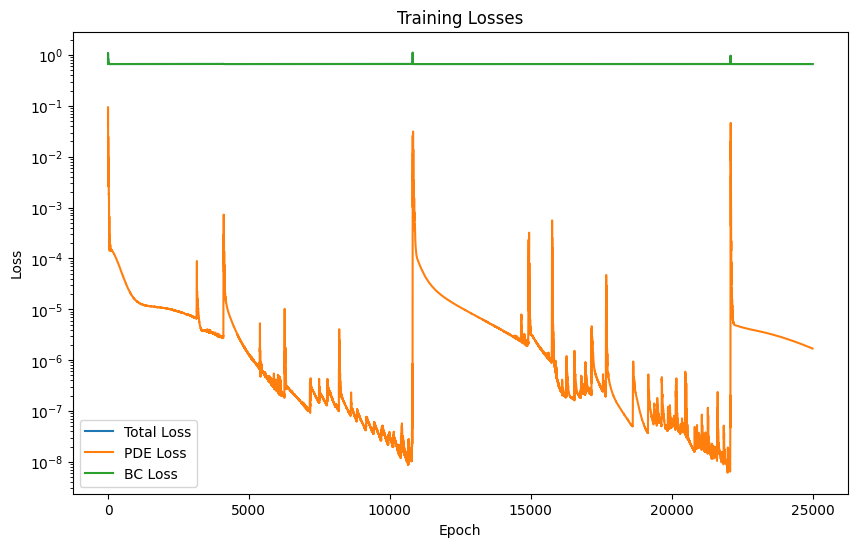

In [14]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Total Loss")
plt.plot(pde_loss_history, label="PDE Loss")
plt.plot(bc_loss_history, label="BC Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

In [15]:
pinn_predictions_filtered = model(tf.constant(Pts, dtype=tf.float32)).numpy()

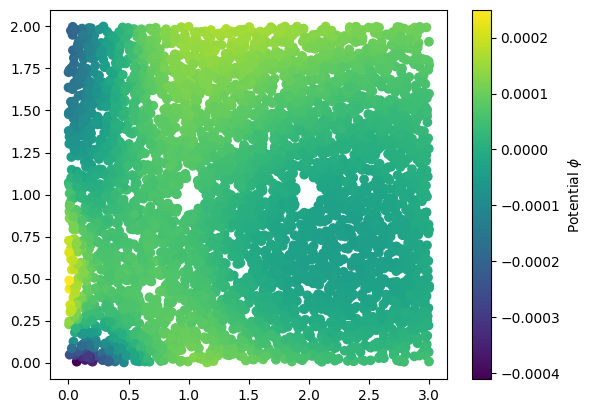

In [16]:
plt.scatter(Pts[:, 0], Pts[:, 1], c=pinn_predictions_filtered.flatten())
plt.colorbar(label="Potential $\phi$")
plt.show()